
# Assignment 2 — Softmax Regression (NumPy-only) on UCI "Predict students’ dropout and academic success"

**Mục tiêu**  
- Xây dựng mô hình **Softmax Regression** chỉ dùng **NumPy**.  
- Huấn luyện bằng **Gradient Descent** trên tập dữ liệu UCI id=697.  
- Đánh giá mô hình (accuracy + macro P/R/F1, ma trận nhầm lẫn).  
- Trực quan hóa **loss** theo epoch.  
- Trực quan hóa **ma trận tương quan** của các thuộc tính số.

**Các điểm quan trọng**  
- Tránh **data leakage**: chuẩn hóa (mean/std) được fit **trên train** và áp dụng cho test.  
- **Stratified split**: chia train/test bảo toàn phân phối lớp.  
- Tùy chọn **one-hot encoding** cho các biến phân loại (mặc định bật) để tận dụng thông tin; mô hình vẫn NumPy-only.


In [1]:

# Imports chung
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cấu hình chung
RANDOM_SEED = 42
TRAIN_RATIO = 0.8
USE_ONE_HOT = True   # True: dùng one-hot cho categorical; False: chỉ dùng cột số
EPOCHS = 500
LR = 0.1

rng = np.random.default_rng(RANDOM_SEED)


## 1) Tải dữ liệu UCI (id=697)

In [2]:

from ucimlrepo import fetch_ucirepo

ds = None
try:
    ds = fetch_ucirepo(id=697)
    X = ds.data.features.copy()
    y = ds.data.targets.copy()  # y['Target'] với {Dropout, Enrolled, Graduate}
    print("Loaded from ucimlrepo. Shapes:", X.shape, y.shape)
    display(X.head(3))
    display(y.head(3))
except Exception as e:
    print("Không thể tải dataset qua ucimlrepo (có thể do offline). Chi tiết:", e)
    print("Có thể thay thế đoạn này bằng việc đọc CSV cục bộ nếu cần.")
    raise


Loaded from ucimlrepo. Shapes: (4424, 36) (4424, 1)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74


,Target
0,Dropout
1,Graduate
2,Dropout


## 2) Khám phá nhanh & ma trận tương quan (các biến số)

Class distribution:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


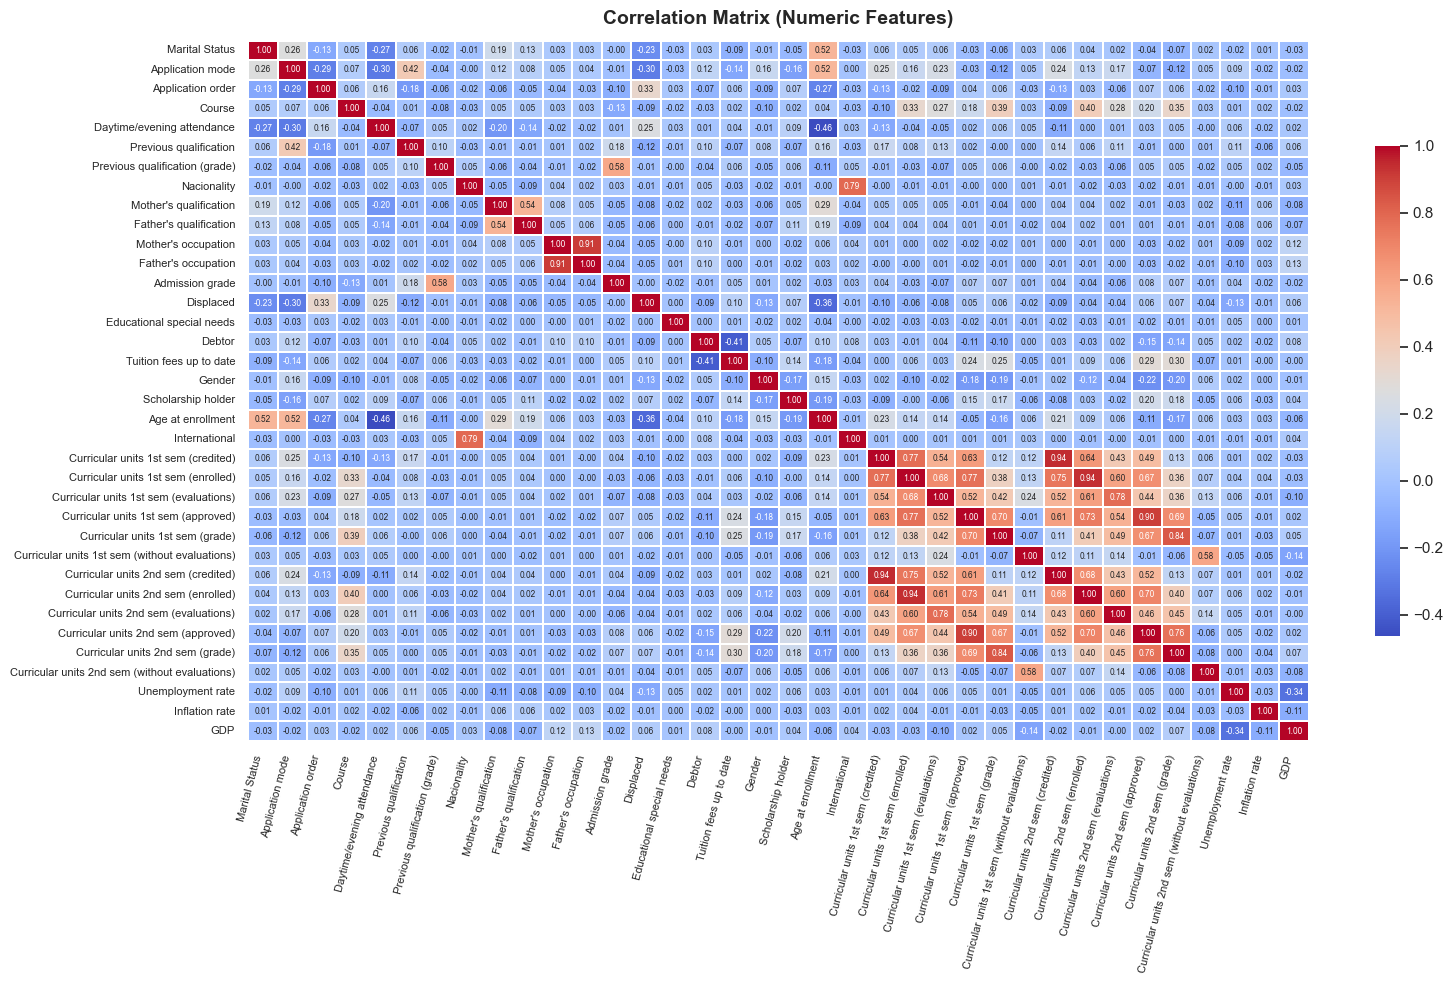

In [11]:
## 2) Khám phá nhanh & ma trận tương quan (các biến số)

from matplotlib import pyplot as plt
import seaborn as sns

# Phân phối lớp
target_col = 'Target' if 'Target' in y.columns else y.columns[0]
y_series = y[target_col].astype(str).str.strip()
print("Class distribution:")
print(y_series.value_counts())

# Ma trận tương quan cho biến số
X_num = X.select_dtypes(include=[np.number]).copy()
corr = X_num.corr(numeric_only=True)

# Vẽ ma trận tương quan
plt.figure(figsize=(16, 10))  # tăng rộng hơn, không ép vuông
sns.set_theme(style="whitegrid")
sns.heatmap(
    corr,
    annot=True,                
    fmt=".2f",
    cmap="coolwarm",            # xanh–đỏ dễ đọc
    cbar_kws={"shrink": 0.7},   # thanh màu gọn
    linewidths=0.3,             # kẻ ô mảnh, tinh tế
    annot_kws={"size": 6}
)
plt.title("Correlation Matrix (Numeric Features)", fontsize=14, weight='bold', pad=12)
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


## 3) Tiền xử lý (multiclass) + stratified split + chuẩn hóa fit trên train

In [4]:

# Mapping nhãn về {0,1,2}
label_map = {'dropout':0, 'enrolled':1, 'graduate':2}
y_lower = y_series.str.lower()

def map_label(t):
    t = t.strip().lower()
    for k in label_map:
        if t.startswith(k):
            return label_map[k]
    raise ValueError(f"Không map được nhãn: {t}")

y_mc = y_lower.map(map_label).values
classes = np.unique(y_mc)
K = int(classes.max() + 1)

# Chuẩn bị features: numeric-only hoặc numeric + one-hot (categorical)
if USE_ONE_HOT:
    # one-hot cho tất cả cột object/category, giữ nguyên numeric
    X_all = pd.get_dummies(X, drop_first=True)
else:
    X_all = X.select_dtypes(include=[np.number]).copy()

# Điền thiếu nếu có
X_all = X_all.fillna(0.0)

# Stratified split 80/20 bằng NumPy
idx_all = np.arange(len(y_mc))
tr_idx_list, te_idx_list = [], []
for c in classes:
    idx_c = idx_all[y_mc == c]
    rng.shuffle(idx_c)
    split_c = int(TRAIN_RATIO * len(idx_c))
    tr_idx_list.append(idx_c[:split_c])
    te_idx_list.append(idx_c[split_c:])
tr_idx = np.concatenate(tr_idx_list)
te_idx = np.concatenate(te_idx_list)
rng.shuffle(tr_idx); rng.shuffle(te_idx)

# Chuẩn hóa: fit trên train, áp cho test
X_mat = X_all.values.astype(float)
Xtr_raw, Xte_raw = X_mat[tr_idx], X_mat[te_idx]

mu = Xtr_raw.mean(axis=0, keepdims=True)
std = Xtr_raw.std(axis=0, keepdims=True) + 1e-8

Xtr = (Xtr_raw - mu) / std
Xte = (Xte_raw - mu) / std

# Thêm bias
Xtr = np.hstack([np.ones((Xtr.shape[0], 1)), Xtr])
Xte = np.hstack([np.ones((Xte.shape[0], 1)), Xte])
ytr, yte = y_mc[tr_idx], y_mc[te_idx]

n, d = Xtr.shape
print(f"Train shape: X={Xtr.shape}, y={ytr.shape}; Test shape: X={Xte.shape}, y={yte.shape}")


Train shape: X=(3538, 37), y=(3538,); Test shape: X=(886, 37), y=(886,)


## 4) Mô hình Softmax Regression (NumPy-only) + Gradient Descent

In [5]:

def softmax(logits):
    # logits: (n, K)
    z = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def nll_loss(logits, y):
    # y: (n,) class indices
    probs = softmax(logits)
    p_true = probs[np.arange(len(y)), y]
    return -np.mean(np.log(p_true + 1e-12))

def one_hot(y, K):
    oh = np.zeros((len(y), K))
    oh[np.arange(len(y)), y] = 1.0
    return oh

# Khởi tạo ngẫu nhiên nhỏ giúp hội tụ mượt hơn
W = rng.normal(0.0, 0.01, size=(d, K))
Ytr = one_hot(ytr, K)

losses = []
for ep in range(EPOCHS):
    logits = Xtr @ W                # (n, K)
    probs = softmax(logits)         # (n, K)
    loss = nll_loss(logits, ytr)
    losses.append(loss)
    grad = (Xtr.T @ (probs - Ytr)) / n
    W -= LR * grad
    if (ep+1) % 50 == 0:
        print(f"Epoch {ep+1}/{EPOCHS}  loss={loss:.4f}")

def predict(W, X):
    logits = X @ W
    return np.argmax(softmax(logits), axis=1)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()


Epoch 50/500  loss=0.6390
Epoch 100/500  loss=0.6078
Epoch 150/500  loss=0.5958
Epoch 200/500  loss=0.5893
Epoch 250/500  loss=0.5850
Epoch 300/500  loss=0.5820
Epoch 350/500  loss=0.5796
Epoch 400/500  loss=0.5777
Epoch 450/500  loss=0.5762
Epoch 500/500  loss=0.5749


## 5) Đánh giá: Accuracy, Macro Precision/Recall/F1, Confusion Matrix

In [6]:

# Dự đoán
yhat_tr = predict(W, Xtr)
yhat_te = predict(W, Xte)

print("Train acc:", accuracy(ytr, yhat_tr))
print("Test  acc:", accuracy(yte, yhat_te))

# Macro Precision/Recall/F1 (NumPy-only)
def prf_macro(y_true, y_pred, K):
    P, R, F = [], [], []
    for k in range(K):
        tp = np.sum((y_true==k) & (y_pred==k))
        fp = np.sum((y_true!=k) & (y_pred==k))
        fn = np.sum((y_true==k) & (y_pred!=k))
        prec = tp / (tp+fp+1e-12)
        rec  = tp / (tp+fn+1e-12)
        f1   = 2*prec*rec / (prec+rec+1e-12)
        P.append(prec); R.append(rec); F.append(f1)
    return np.mean(P), np.mean(R), np.mean(F)

Pm, Rm, Fm = prf_macro(yte, yhat_te, K)
print(f"Macro P/R/F1 (test): {Pm:.3f}/{Rm:.3f}/{Fm:.3f}")

# Confusion matrix
def confusion_matrix_mc(y_true, y_pred, K):
    M = np.zeros((K, K), dtype=int)
    for t, p in zip(y_true, y_pred):
        M[t, p] += 1
    return M

cm = confusion_matrix_mc(yte, yhat_te, K)
print("Confusion matrix (test):\n", cm)


Train acc: 0.7687959299039006
Test  acc: 0.7742663656884876
Macro P/R/F1 (test): 0.716/0.670/0.674
Confusion matrix (test):
 [[231  18  36]
 [ 40  42  77]
 [ 12  17 413]]


## 6) Trực quan hóa Loss theo Epoch

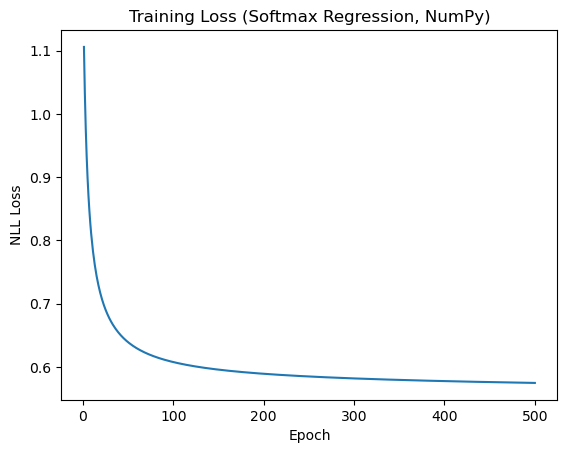

In [7]:

plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("Training Loss (Softmax Regression, NumPy)")
plt.show()



### Ghi chú
- Chuẩn hóa được fit trên train, áp cho test để tránh **data leakage**.
- Chia train/test theo **stratified split** để giữ phân phối lớp.
- `USE_ONE_HOT=True` giúp đưa thông tin từ các cột phân loại vào mô hình; nếu cần tối giản có thể đặt `False` để chỉ dùng thuộc tính số.
- Mô hình Softmax Regression, loss và gradient được triển khai hoàn toàn bằng **NumPy**.
